## Exercise Set 3 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [191]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit
import time

### Exercise 1.

Using Numba, as discussed in [this lecture](https://lectures.quantecon.org/py/need_for_speed.html), write your own version of NumPy's [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) function, specializing in linear interpolation in one dimension.  

Note that NumPy's function is compiled native machine code and hence is fast.  But try to beat if you can, at least in some scenarios, by using Numba to speed up your code.  Show a time comparison between the two functions, for some suitable choice of test.

### Exercise 2

Using your "Numbafied" linear interpolation function, try to use Numba to additionally speed up the endogenous grid method code from [this lecture](https://lectures.quantecon.org/py/egm_policy_iter.html).  Use CRRA utility and Cobb-Douglas production, as in that lecture, with the following parameter values.


Note: I didn't get much speed up.  I think because the outer loops don't matter much for speed, and hence it doesn't gain us much when we compile them.  

See how you go.

### Exercise 1.


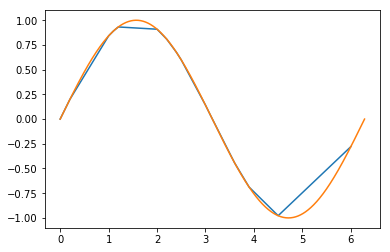

In [297]:
x = np.linspace(0, 2*np.pi, 1000)
sin = np.sin(x)
grid = np.array([0, 0.2, 1, 1.1, 1.2,2, 2.2, 2.4, 2.5, 3, 3.1, 3.6, 3.9, 4.5, 6])
inter = np.interp(grid, x, sin)
plt.plot(grid, inter)
plt.plot(x,sin)
plt.show()

In [257]:
def lin_interp(grid, x, f):
    '''
    x and grid must be arrays and sorted ascending in values.
    grid points must ly within the range of the x provided.
    '''
    df = f[1:] - f[:-1] #np.diff(f)
    dx = x[1:] - x[:-1] #np.diff(x)
    b =  df / dx
    bins = np.digitize(grid, x) - 1
    grid_diff = grid - x[bins]
    return f[bins] + b[bins] * grid_diff

In [334]:
def lin_interp_broadcast(grid, x, f):
    '''
    x and grid must be arrays and sorted ascending in values.
    grid points must ly within the range of the x provided.
    '''
    df = f[1:] - f[:-1] #np.diff(f)
    dx = x[1:] - x[:-1] #np.diff(x)
    b =  df / dx
    gridx = grid.reshape(len(grid), 1).copy()
    all_bins = gridx - x
    np.place(all_bins, all_bins < 0, 9999999)
    all_bins.shape
    binsx = np.argmin(all_bins, axis=1)

    grid_diff = grid - x[bins]
    return f[bins] + b[bins] * grid_diff

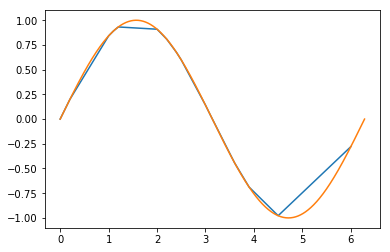

In [328]:
f_new = lin_interp(grid, x, sin)
plt.plot(grid, f_new)
plt.plot(x ,sin)
plt.show()

#### Compare the numpy function to my function interpolating a function of 1000 points by:

In [261]:
x = np.linspace(0, 2*np.pi, 1000)
sin = np.sin(x)
grid = np.array([0, 0.2, 1, 1.1, 1.2,2, 2.2, 2.4, 2.5, 3, 3.1, 3.6, 3.9, 4.5, 6])

In [335]:
interp_numba = jit(lin_interp)
interp_numba_broadcast = jit(lin_interp_broadcast)

In [264]:
%timeit interp_numba(grid, x, sin)

The slowest run took 5.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 6.87 µs per loop


In [337]:
%timeit interp_numba_broadcast(grid, x, sin)

The slowest run took 14.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 98.9 µs per loop


In [263]:
% timeit np.interp(grid, x, sin)

The slowest run took 12.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.44 µs per loop


#### Compare that to the numbafied interpolating a function of only 10 points:

In [265]:
x = np.linspace(0, 2*np.pi, 10)
sin = np.sin(x)

In [266]:
%timeit interp_numba(grid, x, sin)

The slowest run took 7.63 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.33 µs per loop


In [267]:
% timeit np.interp(grid, x, sin)

The slowest run took 11.62 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.34 µs per loop


I don't think I can get any faster than that since I am not using any loops and I cannot replace the division and the multiplication by anything to speed it up further. However, when x is not very large am about as fast as numpy's function (Writing "df = f[1:] - f[:-1]" instead of df.diff(f) gave an additional speed up). However, when the length of x increases my numbafied function slows down significantly whereas, numpy's function keeps the same speed.

As you can see in my attempt to replace the np.digitize() function by broadcasting, this slowed down the function significantly. I give up here ;)


### Exercise 2

In [338]:
import quantecon as qe

In [355]:
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg

In [354]:
def coleman_egm_numba(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: interp_numba(x, y, c)
    return Kg

In [340]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

In [341]:
lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

In [342]:
grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

In [369]:
alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

## Let's make convenience functions based around these primitives

def crra_coleman_egm_myfun(g):
    return coleman_egm_numba(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)

egm_numba = jit(crra_coleman_egm_myfun)

def crra_coleman_egm(g):
    return coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)

In [371]:
## Iterate, compare policies

sim_length = 20

print("Timing my modified Coleman EGM")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = egm_numba(g)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g)
    g = new_g
qe.util.toc()

Timing my modified Coleman EGM
TOC: Elapsed: 0.16024255752563477 seconds.
Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.1441640853881836 seconds.


0.1441640853881836

Using numba again on the modified colemen_egm() operator gives me speed close to the original quantecon function but not beyond.